IMPORTAÇÕES DE BIBLIOTECAS & PARÂMETROS GERAIS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Parâmetros da simulação ---

n = 5                        # Número de estados do autômato (n)
dt = 1e-3                    # Passo de tempo = 1 ms  - t é o tempo dado em ms
T = 10000                   # Número total de passos de tempo
L = 1000                     # Número de neurônios
r_valores = np.logspace(-3, 3, 10)  # Taxas de estímulo (de 1 Hz a 1000 Hz)
Dn = n * dt                       # Período refratário absoluto

#----- Conferência parâmetros ----
#n,dt,T,L,r_valores,Dn

EVOLUÇÃO DO ESTÍMULO POR POISSON - CÉLULA ´NICA E NÃO ACOPLADA COM N = 5

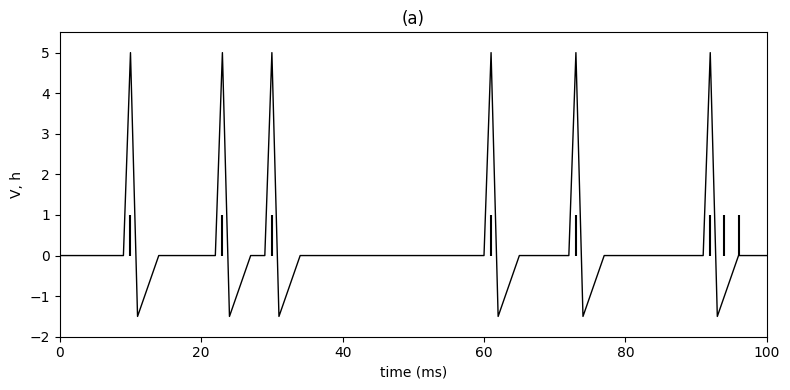

In [ ]:
#--- Simulação da evolução do estímulo para uma única célula não acoplada de cinco estados (considerando Poisson) ---


V0 = 5
r0 = 100
k = 0.3

states = np.zeros(T, dtype=int)
V = np.zeros(T)
h = np.zeros(T)

for t in range(1, T):
    # Estímulo externo (Poisson): probabilidade de spike = r*dt
    h[t] = int(np.random.rand() < r0 * dt)

    if states[t-1] == 0:
        if h[t] == 1:
            states[t] = 1
        else:
            states[t] = 0
    else:
        states[t] = (states[t-1] + 1) % n

 # Cálculo de V(x)
    xi = states[t]
    if xi == 1:
        V[t] = V0
    elif xi != 0:
        V[t] = -V0 * k * (1 - ((xi - 2) / (n - 2)))
    else:
        V[t] = 0

# Plotando o gráfico
time = np.arange(T)

plt.figure(figsize=(8, 4))
plt.plot(time, V, 'k', linewidth=1)
plt.vlines(time[h == 1], ymin=0, ymax=1, color='black')  # estímulos
plt.ylim(-2, 5.5)
plt.xlim(0, 100)
plt.xlabel('time (ms)')
plt.ylabel('V, h')
plt.title('(a)')
plt.tight_layout()
plt.show()


#Curvas com picos de disparo (V = 5) sempre que a célula dispara.
#Durante o período refratário, o valor de V decai até voltar a 0.
#Barras verticais na parte inferior representam os estímulos Poisson ℎ(t)


SIMULAÇÃO DO ESTÍMULO EM CÉLULA NÃO ACOPLADA - SEM REPETIÇÕES

In [ ]:
# --- Função simulação sistema não acoplado ---
def simulate_uncoupled_neurons(r, L=L, T=T, n=n, dt=dt):
    states = np.zeros(L, dtype=int)  # Todos os neurônios começam no estado 0
    spikes = np.zeros(L)              # Contador de spikes por neurônio

    for t in range(T):
        # Estímulos externos: probabilidade de spike no passo dt é r*dt
        input_stimulus = np.random.rand(L) < r * dt

        # Neurônios em estado 0 podem disparar se receberem estímulo
        firing_now =  (states == 0) & input_stimulus
        spikes += firing_now

        # Atualizando os estados:
        # Se disparou agora, vai para o estado 1
        states[firing_now] = 1

        # Os neurônios que estão nos estados 1 a n-2 avançam 1
        advancing = (states > 0)
        states[advancing] += 1
        states[states == n] = 0  # volta para estado de repouso após n-1

    firing_rate_nacoplado = np.sum(spikes)  / (L * T * dt)  # spikes/seg por neurônio
    return firing_rate_nacoplado



In [ ]:
#Para vários valores de r

firing_rates_nacoplado = []
for r in r_valores:
    f = simulate_uncoupled_neurons(r)
    firing_rates_nacoplado.append(f)
#f
#firing_rates_nacoplado

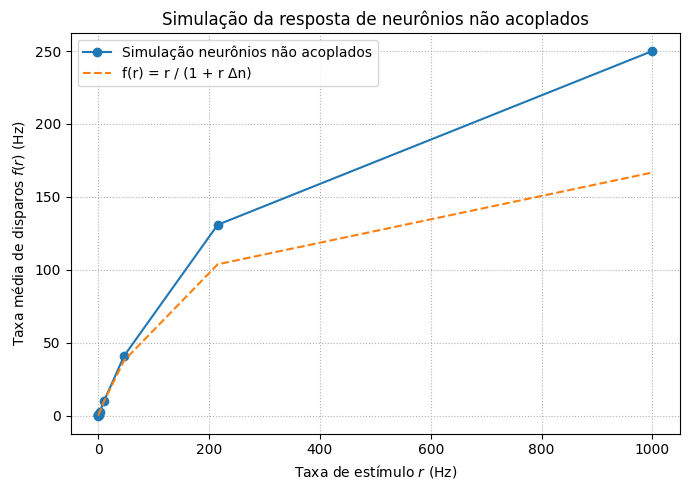

In [ ]:
#Plotando os gráficos da simulações dos sistema sem acoplamento ainda sem escala log

plt.figure(figsize=(7,5))
plt.plot(r_valores, firing_rates_nacoplado, 'o-', label='Simulação neurônios não acoplados')
plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='f(r) = r / (1 + r Δn)')

# Define os nomes dos eixos
plt.xlabel('Taxa de estímulo $r$ (Hz)')
plt.ylabel('Taxa média de disparos $f(r)$ (Hz)')

# Define o título do gráfico
plt.title('Simulação da resposta de neurônios não acoplados')

# Adição da legenda
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()




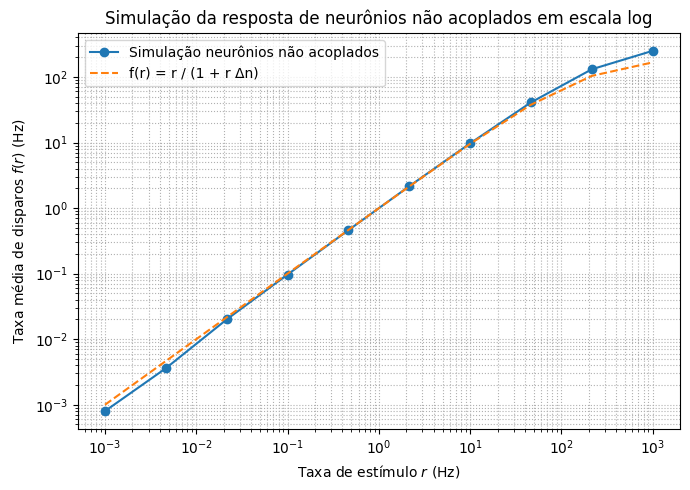

In [ ]:
#Plotando os gráficos da simulações dos sistema sem acoplamento em escala log

plt.figure(figsize=(7,5))
plt.plot(r_valores, firing_rates_nacoplado, 'o-', label='Simulação neurônios não acoplados')
plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='f(r) = r / (1 + r Δn)')

#Passando apra a escala log do artigo
plt.xscale('log')
plt.yscale('log')

# Define os nomes dos eixos
plt.xlabel('Taxa de estímulo $r$ (Hz)')
plt.ylabel('Taxa média de disparos $f(r)$ (Hz)')

# Define o título do gráfico
plt.title('Simulação da resposta de neurônios não acoplados em escala log')

# Adição da legenda
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


SIMULAÇÃO DO ESTÍMULO EM CÉLULAS ACOPLADAS

In [ ]:
# --- Função simulação sistema acoplado ---

def simulate_coupled_neurons(r, L=L, T=T, n=n, dt=dt):
    states = np.zeros(L, dtype=int)
    spikes = np.zeros(L)

    for t in range(T):
        # Estímulo externo (Poisson)
        input_stimulus = np.random.rand(L) < r * dt

        # Vizinhos: estado anterior (t) de cada célula
        left_neighbor_spike = np.roll(states == 1, +1)  # vizinho à esquerda
        right_neighbor_spike = np.roll(states == 1, -1) # vizinho à direita

        # h_i(t): entrada "acoplada"
        effective_input = input_stimulus | left_neighbor_spike | right_neighbor_spike

        # Só pode disparar se estiver em estado 0 (repouso)
        firing_now = (states == 0) & effective_input
        spikes += firing_now

        # Atualiza estado dos que dispararam agora
        states[firing_now] = 1

        # Atualiza estados dos que estão em período refratário
        advancing = (states > 0)
        states[advancing] += 1
        states[states == n] = 0  # volta ao repouso após n-1

    firing_rate_acoplado = np.sum(spikes) / (L * T * dt)  # média por neurônio
    return firing_rate_acoplado


In [ ]:
#Para muitos valores de r
firing_coupled = [simulate_coupled_neurons(r) for r in r_valores]
firing_coupled



[np.float64(0.0009),
 np.float64(0.0043),
 np.float64(0.0214),
 np.float64(0.0981),
 np.float64(0.4527),
 np.float64(2.1482),
 np.float64(9.7151),
 np.float64(40.7996),
 np.float64(130.7751),
 np.float64(250.0)]

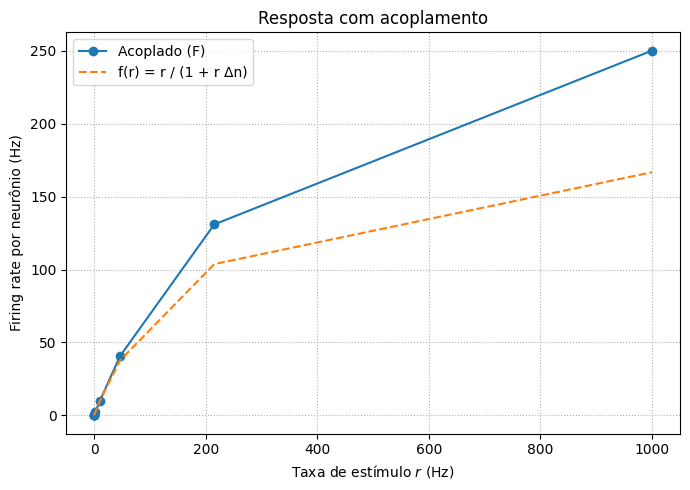

In [ ]:
#Plotando o gráfico da simulação dos sistema com acoplamento ainda sem escala log

plt.figure(figsize=(7,5))
plt.plot(r_valores, firing_coupled, 'o-', label='Acoplado (F)')
plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='f(r) = r / (1 + r Δn)')
#plt.xscale('log')
#plt.yscale('log')

# Definindo nome dos eixos
plt.xlabel('Taxa de estímulo $r$ (Hz)')
plt.ylabel('Firing rate por neurônio (Hz)')

# Título do gráfico
plt.title('Resposta com acoplamento')


plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()


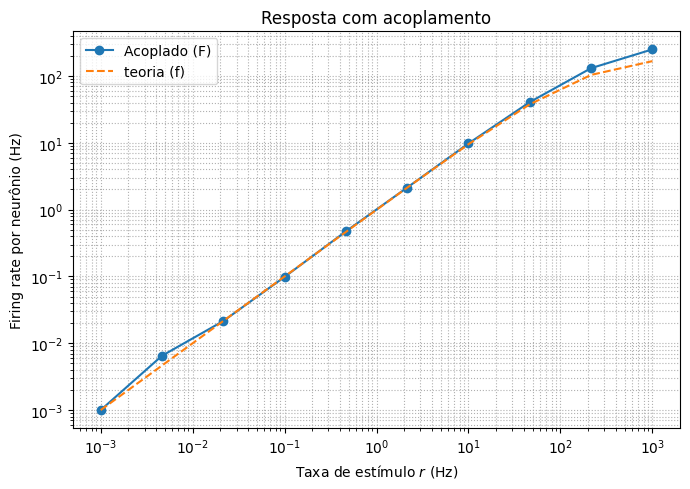

In [ ]:
#Plotando o gráfico da simulação do sistema com acoplamento em escala log

firing_coupled = [simulate_coupled_neurons(r) for r in r_valores]

plt.figure(figsize=(7,5))
plt.plot(r_valores, firing_coupled, 'o-', label='Acoplado (F)')
plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='teoria (f)')

#Passando para escala log
plt.xscale('log')
plt.yscale('log')

# Definindo nome dos eixos
plt.xlabel('Taxa de estímulo $r$ (Hz)')
plt.ylabel('Firing rate por neurônio (Hz)')

# Título do gráfico
plt.title('Resposta com acoplamento')


plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()

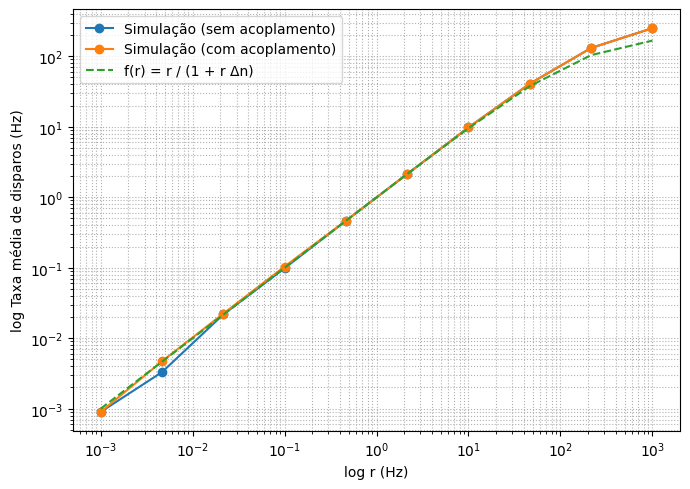

Text(0.5, 1.0, 'Simulação da resposta de neurônios')

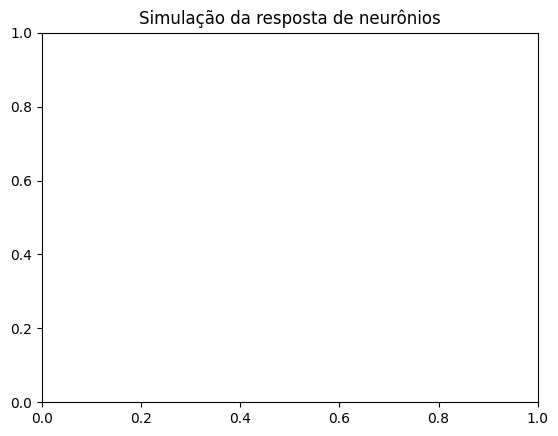

In [ ]:
#Plotando o gráfico de COMPARAÇÃO da simulações dos sistema sem e com acoplamento em escala log

f_uncoupled = [simulate_uncoupled_neurons(r, n=n, dt=dt) for r in r_valores]
f_coupled   = [simulate_coupled_neurons(r, n=n, dt=dt)   for r in r_valores]

plt.figure(figsize=(7,5))
plt.plot(r_valores, f_uncoupled, 'o-', label='Simulação (sem acoplamento)')
plt.plot(r_valores, f_coupled, 'o-', label='Simulação (com acoplamento)')
plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='f(r) = r / (1 + r Δn)')

#Passa para a escala logaritma
plt.xscale('log')
plt.yscale('log')

# Define os nomes dos eixos

plt.xlabel('log r (Hz)')
plt.ylabel('log Taxa média de disparos (Hz)')

#Adição de legenda
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


# Define o título do gráfico
plt.title('Simulação da resposta de neurônios')



SIMULAÇÃO DO ESTÍMULO EM CÉLULA NÃO ACOPLADA E COM ACOPLAMENTO - AGORA COM REPETIÇÕES PARA REDUZIR O RUÍDO DAS RESPOSTAS

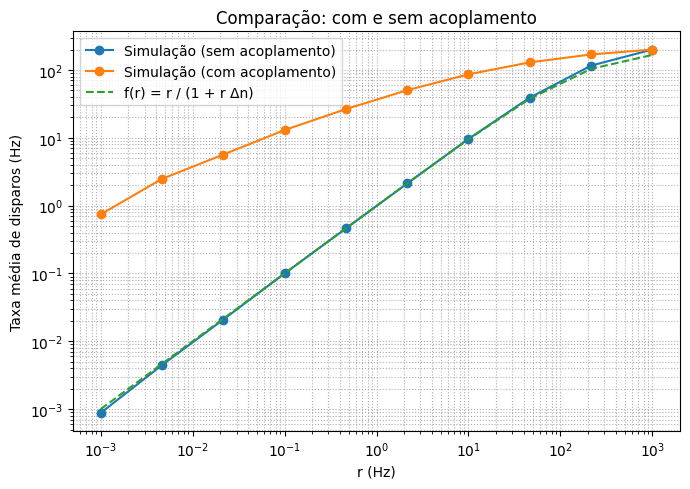

In [ ]:
 # ---- Simulação aplicando repetições para tirar ruído ---

repetitions = 5  # número de repetições por valor de r

# --- funções de simulação ---
def simulate_uncoupled_neurons(r, L=L, T=T, n=n, dt=dt):
    states = np.zeros(L, dtype=int)
    spikes = 0
    for _ in range(T):
        stimulus = np.random.rand(L) < r * dt
        firing_now = (states == 0) & stimulus
        spikes += np.sum(firing_now)
        states[firing_now] = 1
        refractory = (states > 0) & (~firing_now)
        states[refractory] += 1
        states[states == n] = 0
    return spikes / (L * T * dt)

def simulate_coupled_neurons(r, L=L, T=T, n=n, dt=dt):
    states = np.zeros(L, dtype=int)
    spikes = 0
    for _ in range(T):
        stimulus = np.random.rand(L) < r * dt
        left_spike = np.roll(states == 1, +1)
        right_spike = np.roll(states == 1, -1)
        effective_input = stimulus | left_spike | right_spike
        firing_now = (states == 0) & effective_input
        spikes += np.sum(firing_now)
        states[firing_now] = 1
        refractory = (states > 0) & (~firing_now)
        states[refractory] += 1
        states[states == n] = 0
    return spikes / (L * T * dt)

# --- cálculo com médias ---
def media_firing_rate(sim_func, r, reps):
    return np.mean([sim_func(r) for _ in range(reps)])

f_uncoupled = [media_firing_rate(simulate_uncoupled_neurons, r, repetitions) for r in r_valores] #Calcula a média para o não acoplado
f_coupled   = [media_firing_rate(simulate_coupled_neurons, r, repetitions) for r in r_valores] #Calcula a média para o acoplado
f_n   = r_valores / (1 + r_valores * Dn)

# --- plot ---
plt.figure(figsize=(7,5))
plt.plot(r_valores, f_uncoupled, 'o-', label='Simulação (sem acoplamento)')
plt.plot(r_valores, f_coupled, 'o-', label='Simulação (com acoplamento)')
plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='f(r) = r / (1 + r Δn)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (Hz)')
plt.ylabel('Taxa média de disparos (Hz)')
plt.title('Comparação: com e sem acoplamento')
plt.grid(True, which='both', ls=':')
plt.legend()
plt.tight_layout()
plt.show()


SIMULANDO SEM E COM ACOPLAMENTO, COM REPETIÇÕES E VARIANDO O L E O N

In [ ]:
# --- Cálculos variand L e n - versão enxuta ---

# --- Variando L ---
valoresL = [200, 1000, 5000]
resL_uncoupled = {}
resL_coupled = {}

# --- loop para calcular firing rate médio para cada L ---
for L in valoresL:
    # Não acoplado
    resL_uncoupled[L] = [
        media_firing_rate(lambda r_: simulate_uncoupled_neurons(r_, L=L, T=T, n=3, dt=dt),
                          r, repetitions)
        for r in r_valores
    ]

    # Acoplado
    resL_coupled[L] = [
        media_firing_rate(lambda r_: simulate_coupled_neurons(r_, L=L, T=T, n=3, dt=dt),
                          r, repetitions)
        for r in r_valores
    ]

# --- Variando n ---

valoresn = [3, 10, 50]
resn_uncoupled = {}
resn_coupled = {}

# --- loop para calcular firing rate médio para cada n ---
for n in valoresn:
    # Não acoplado
    resn_uncoupled[n] = [
        media_firing_rate(lambda r_: simulate_uncoupled_neurons(r_, L=5000, T=T, n=n, dt=dt),
                          r, repetitions)
        for r in r_valores
    ]

    # Acoplado
    resn_coupled[n] = [
        media_firing_rate(lambda r_: simulate_coupled_neurons(r_, L=5000, T=T, n=n, dt=dt),
                          r, repetitions)
        for r in r_valores
    ]

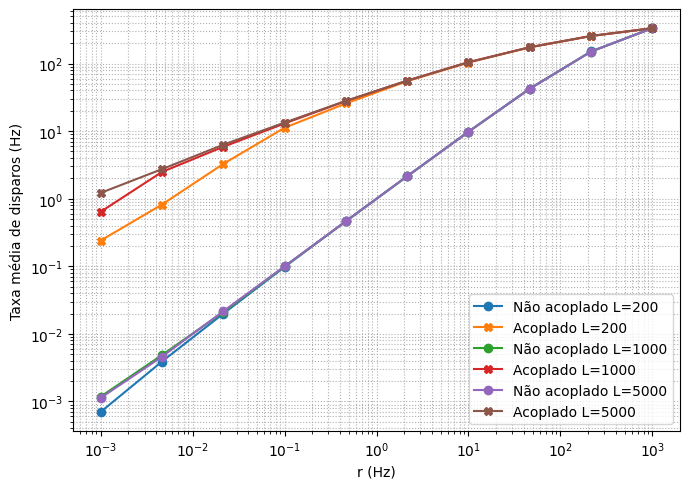

In [ ]:
# --- Plot da forma enxuta ---

#Variando L

plt.figure(figsize=(7,5))

for L in valoresL:
    plt.plot(r_valores, resL_uncoupled[L], 'o-', label=f'Não acoplado L={L}')
    plt.plot(r_valores, resL_coupled[L], 'X-', label=f'Acoplado L={L}')


#plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='f(r) = r / (1 + r Δn)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (Hz)')
plt.ylabel('Taxa média de disparos (Hz)')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

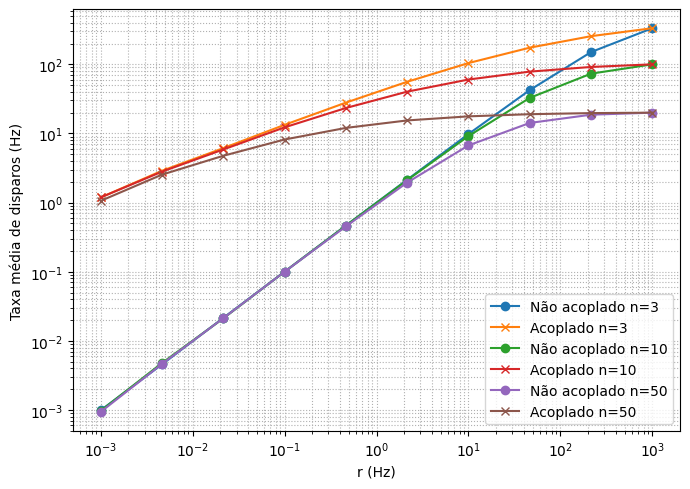

In [ ]:
# --- Plot da forma enxuta ---

#Variando n

plt.figure(figsize=(7,5))

for n in valoresn:
    plt.plot(r_valores, resn_uncoupled[n], 'o-', label=f'Não acoplado n={n}')
    plt.plot(r_valores, resn_coupled[n], 'x-', label=f'Acoplado n={n}')

#plt.plot(r_valores, r_valores / (1 + r_valores * Dn), '--', label='f(r) = r / (1 + r Δn)')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (Hz)')
plt.ylabel('Taxa média de disparos (Hz)')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()

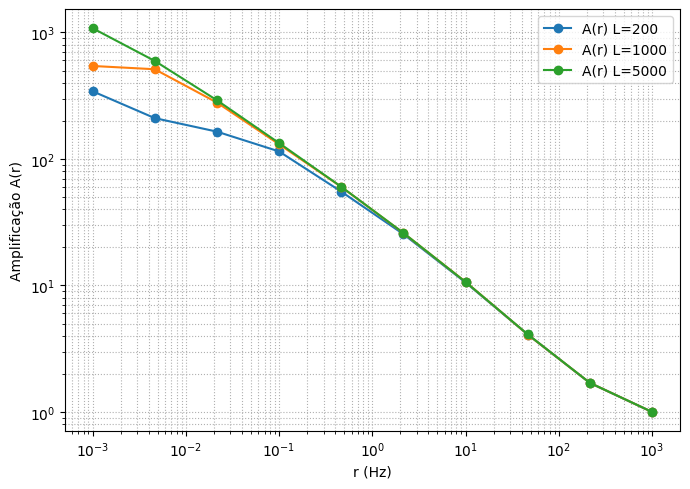

In [ ]:
# --- Fator de Amplificação n = cte e L variando ---

# A = F/f (F = acoplado e f = não acopaldo)

#Variando L
amplificationfactorL = {}

for L in valoresL:
    f_unc = np.array(resL_uncoupled[L])
    f_cou = np.array(resL_coupled[L])
    amplificationfactorL[L] = f_cou / f_unc



# --- plot ---


plt.figure(figsize=(7,5))

for L in valoresL:
    plt.plot(r_valores, amplificationfactorL[L], 'o-', label=f'A(r) L={L}')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (Hz)')
plt.ylabel('Amplificação A(r)')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


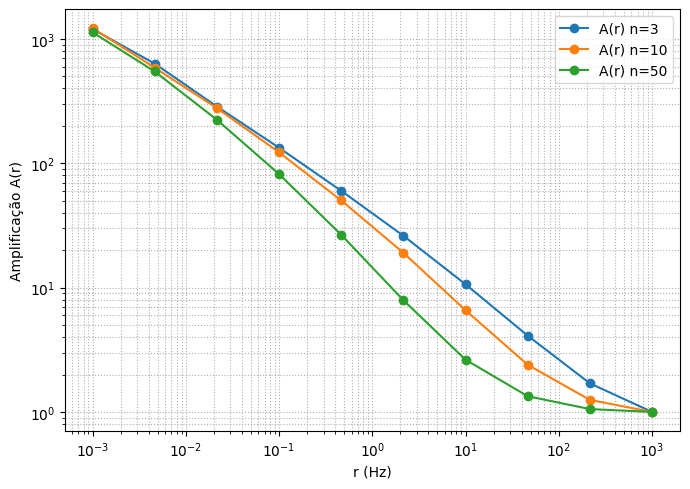

In [ ]:
# --- Fator de Amplificação L cte e n variando ---

# A = F/f (F = acoplado e f = não acopaldo)

#Variando n
amplificationfactorn = {}

for n in valoresn:
    f_unc = np.array(resn_uncoupled[n])
    f_cou = np.array(resn_coupled[n])
    amplificationfactorn[n] = f_cou / f_unc


# --- plot ---

plt.figure(figsize=(7,5))
for n in valoresn:
    plt.plot(r_valores, amplificationfactorn[n], 'o-', label=f'A(r) n={n}')


plt.xscale('log')
plt.yscale('log')
plt.xlabel('r (Hz)')
plt.ylabel('Amplificação A(r)')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


VARIANDO L E N (L = 5000 OU 2500)



In [ ]:
# --- parâmetros ---
dt = 1e-3
T_min, T_max = 5000, 20000
reps = 5
rng = np.random.default_rng(123)

r_values = np.logspace(-6, 3, 20)
# n_values = [50, 20, 10, 3]
# L_values = [5000, 25000]


# --- simulador acoplado (L = 5000 e variando n igual antes) ---

L5000_valoresn = [3, 10, 20, 50]
L25000_valorn = [3,10,20,50] # Only n=50 for L=25000 based on the plot code

# --- loop para calcular firing rate médio para cada n ---
def simulate_coupled_F(r, L, n, dt=dt, T=10000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    states = np.zeros(L, dtype=int)
    spikes = 0
    for _ in range(T):
        stimulus = rng.random(L) < r * dt
        left_spike  = np.roll(states == 1, +1)
        right_spike = np.roll(states == 1, -1)
        effective_input = stimulus | left_spike | right_spike
        firing_now = (states == 0) & effective_input
        spikes += firing_now.sum()
        states[firing_now] = 1
        refractory = (states > 0) & (~firing_now)
        states[refractory] += 1
        states[states == n] = 0
    F = spikes / (L * T * dt)
    return F

def media_F(r, L, n, dt, reps, rng):
    K = 25 #garante que independente do valor de r (grande ou pequeno), serão observados eventos de estímulo
    T_adapt = int(np.clip(np.ceil(K / max(r*dt, 1e-12)), T_min, T_max))
    return np.mean([simulate_coupled_F(r, L=L, n=n, dt=dt, T=T_adapt, rng=rng)
                    for _ in range(reps)])

# --- rodar simulações ---
results_F50 = {}      # guarda F(r)
results_FDelta50 = {} # guarda F(r) * Δ
results_F25 = {}      # guarda F(r)
results_FDelta25 = {} # guarda F(r) * Δ

for n in L5000_valoresn:
    F_vals5000 = np.array([media_F(r, L=5000, n=n, dt=dt, reps=reps, rng=rng)
                           for r in r_values])
    Delta5000 = n * dt
    results_F50[(5000, n)] = F_vals5000
    results_FDelta50[(5000, n)] = F_vals5000 * Delta5000

for n in L25000_valorn:
    F_vals25000 = np.array([media_F(r, L=25000, n=n, dt=dt, reps=reps, rng=rng)
                           for r in r_values])
    Delta25000 = n * dt
    results_F25[(25000, n)] = F_vals25000
    results_FDelta25[(25000, n)] = F_vals25000 * Delta25000

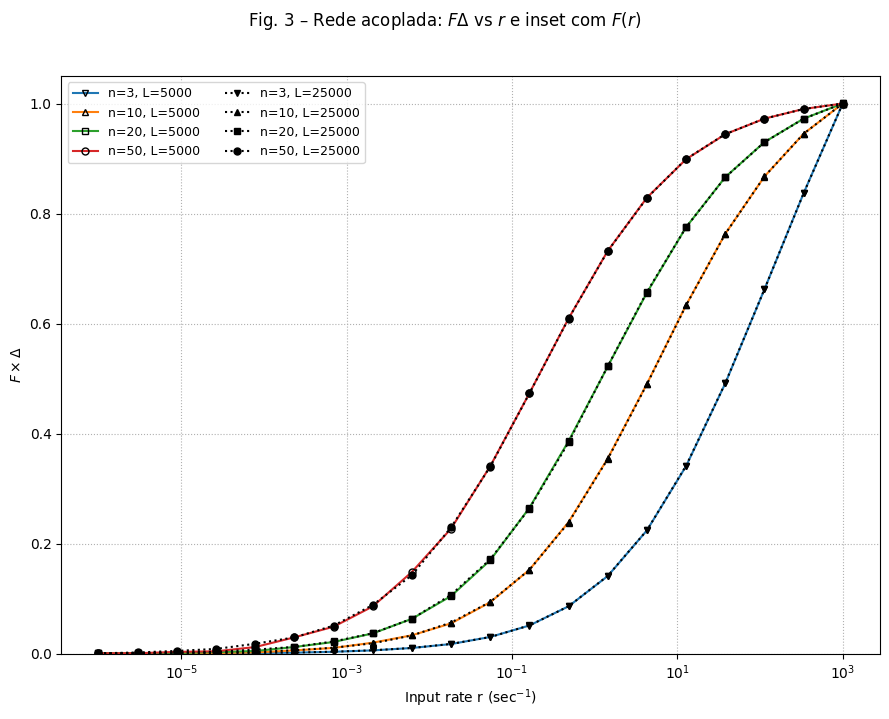

In [ ]:
# --- plot principal  ---
markers = {50:'o', 20:'s', 10:'^', 3:'v'}

fig, ax = plt.subplots(figsize=(9, 7))

# plot principal (FΔ vs r)
for n in L5000_valoresn:
    ax.plot(r_values, results_FDelta50[(5000, n)],
             linestyle='-', marker=markers[n], markersize=5,
             markerfacecolor='none', markeredgecolor='black',
             label=f"n={n}, L=5000")

for n in L25000_valorn:
    ax.plot(r_values, results_FDelta25[(25000, n)],
             linestyle=':', marker=markers[n], markersize=5,
             color='black', label=f"n={n}, L=25000")

ax.set_xscale('log')
ax.set_ylim(0, 1.05)
ax.set_xlabel("Input rate r (sec$^{-1}$)")
ax.set_ylabel(r"$F \times \Delta$")
ax.grid(True, which='both', ls=':')
ax.legend(ncol=2, fontsize=9)

# # inset (F vs r, log-log)
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# ax_inset = inset_axes(ax, width="45%", height="45%", loc="upper left")

# n_ref, L_ref = 50, 5000  # podemos usar n=50, L=5000 como no artigo
# ax_inset.plot(r_values, results_F[(L_ref, n_ref)], 'ko-', markersize=4)

# ax_inset.set_xscale('log')
# ax_inset.set_yscale('log')
# ax_inset.set_xlabel("r", fontsize=10)
# ax_inset.set_ylabel("F(r)", fontsize=10)
# ax_inset.tick_params(axis='both', which='major', labelsize=8)

plt.suptitle("Fig. 3 – Rede acoplada: $F\\Delta$ vs $r$ e inset com $F(r)$", y=1.02)
plt.tight_layout()
plt.show()

MODELO DA LEI DE STEVENS - com refratariedade (análise para pontos médios de r)





🚀 INICIANDO SIMULAÇÃO COM REPETIÇÕES...
Configuração: 15 pontos × 5 repetições = 75 simulações por caso

📊 Caso: n=15, τ=10
  r = 0.001: 1.38 1.39 0.91 1.34 1.87→ média = 1.378 ± 0.303
  r = 0.003: 2.56 2.28 2.31 2.68 2.25→ média = 2.413 ± 0.171
  r = 0.007: 4.40 4.53 3.98 4.27 3.91→ média = 4.219 ± 0.241
  r = 0.019: 6.92 6.88 6.88 6.79 6.94→ média = 6.884 ± 0.050
  r = 0.052: 11.10 10.61 10.97 10.70 10.50→ média = 10.775 ± 0.225
  r = 0.139: 16.41 16.21 16.65 16.52 16.65→ média = 16.490 ± 0.165
  r = 0.373: 24.69 23.99 24.76 24.27 24.38→ média = 24.419 ± 0.283
  r = 1.000: 33.81 33.75 33.88 33.55 33.70→ média = 33.736 ± 0.112
  r = 2.683: 44.13 44.13 44.32 44.11 44.22→ média = 44.181 ± 0.078
  r = 7.197: 54.54 54.42 54.44 54.38 54.47→ média = 54.449 ± 0.054
  r = 19.307: 63.45 63.39 63.40 63.45 63.42→ média = 63.420 ± 0.025
  r = 51.795: 75.83 75.84 75.84 75.86 75.85→ média = 75.844 ± 0.009
  r = 138.950: 117.09 117.10 117.07 117.06 117.06→ média = 117.075 ± 0.018
  r = 372.759: 183.

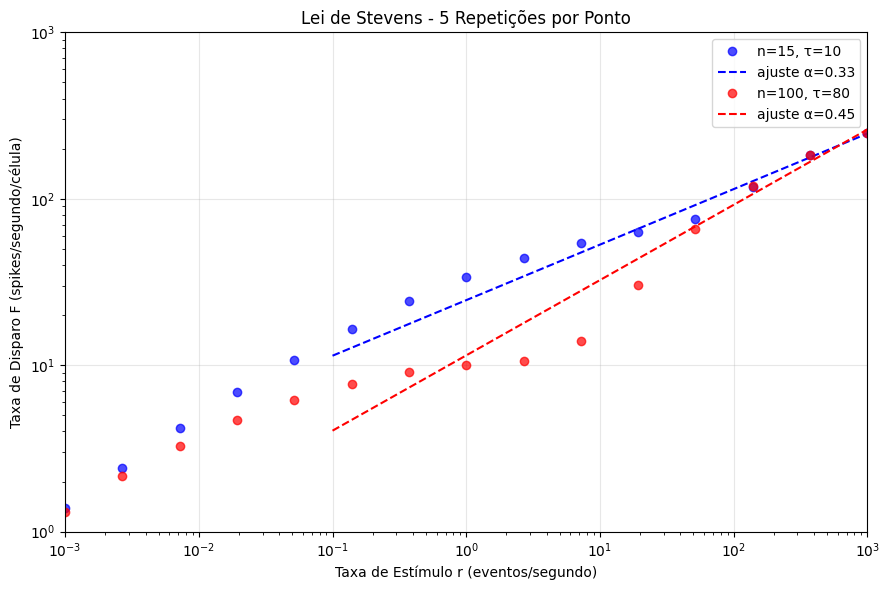


🎯 ESTRATÉGIA DE REPETIÇÕES ADAPTATIVAS
(Executa mais repetições apenas onde a variabilidade é alta)

n=15, τ=10:
  Ponto com maior variabilidade (CV=0.220): r = 0.001
  Executando 5 repetições extras neste ponto...
  Nova média: 1.433 ± 0.230
  Melhoria na precisão: 1.3x

n=100, τ=80:
  Variabilidade é baixa (CV max = 0.059). Não há necessidade de refinar.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import datetime

# ====================
# PARÂMETROS OTIMIZADOS COM REPETIÇÕES
# ====================
L = 2500            # Tamanho da rede (balanceado entre velocidade e estabilidade)
T = 20000           # Tempo total de simulação
transiente = 4000   # Período transiente
repeticoes = 5     # Número de repetições para cada ponto

casos = [
    {'n': 15, 'M': 3, 'tau': 10, 'limiar': 2.0, 'color': 'blue', 'label': 'n=15, τ=10'},
    {'n': 100, 'M': 3, 'tau': 80, 'limiar': 2.0, 'color': 'red', 'label': 'n=100, τ=80'}
]

# Pontos otimizados - menos pontos mas bem distribuídos
r_values = np.logspace(-3, 3, 15)  # 8 pontos de 0.001 a 1000

# ====================
# FUNÇÃO SIMULADORA (MANTIDA RÁPIDA)
# ====================
def simulate_fast(r, n, M, tau, limiar, L, T, transiente):
    states = np.zeros(L, dtype=int)
    stimulus_counters = np.zeros(L)
    spike_counts = np.zeros(L)

    for t in range(T):
        new_states = states.copy()
        external_stimuli = np.random.random(L) < (r / 1000.0)

        for i in range(L):
            left_idx = (i-1) % L
            right_idx = (i+1) % L
            total_stimulus = external_stimuli[i] or (states[left_idx] == 1) or (states[right_idx] == 1)

            if states[i] == 0:
                if total_stimulus:
                    new_states[i] = 1
                    spike_counts[i] += 1
                    stimulus_counters[i] = 0

            elif 1 <= states[i] <= M:
                new_states[i] = (states[i] + 1) % n
                stimulus_counters[i] = 0

            elif M < states[i] < n-1:
                if total_stimulus:
                    stimulus_counters[i] += 1

                if stimulus_counters[i] >= limiar:
                    new_states[i] = 1
                    spike_counts[i] += 1
                    stimulus_counters[i] = 0
                else:
                    new_states[i] = states[i] + 1

            elif states[i] == n-1:
                new_states[i] = 0
                stimulus_counters[i] = 0

        states = new_states

    tempo_util = (T - transiente) / 1000.0
    F = np.sum(spike_counts) / (L * tempo_util)
    return F

# ====================
# FUNÇÃO DE LEI DE STEVENS
# ====================
def stevens_law(r, alpha, C):
    return C * (r ** alpha)

# ====================
# SIMULAÇÃO COM REPETIÇÕES INTELIGENTES
# ====================
plt.figure(figsize=(9, 6))

print("🚀 INICIANDO SIMULAÇÃO COM REPETIÇÕES...")
print(f"Configuração: {len(r_values)} pontos × {repeticoes} repetições = {len(r_values) * repeticoes} simulações por caso")

for caso in casos:
    print(f"\n📊 Caso: {caso['label']}")

    n, M, tau, limiar = caso['n'], caso['M'], caso['tau'], caso['limiar']
    F_medias = []
    F_desvios = []  # Para armazenar desvios padrão
    F_todas_repeticoes = []  # Para debug e análise

    tempo_inicio_caso = datetime.datetime.now()

    for i, r in enumerate(r_values):
        print(f"  r = {r:.3f}: ", end="")
        F_repeticoes = []

        for rep in range(repeticoes):
            F = simulate_fast(r, n, M, tau, limiar, L, T, transiente)
            F_repeticoes.append(F)
            print(f"{F:.2f}", end=" " if rep < repeticoes-1 else "")

        F_media = np.mean(F_repeticoes)
        F_desvio = np.std(F_repeticoes)

        F_medias.append(F_media)
        F_desvios.append(F_desvio)
        F_todas_repeticoes.append(F_repeticoes)

        print(f"→ média = {F_media:.3f} ± {F_desvio:.3f}")

    # Armazena resultados
    caso['F_medias'] = np.array(F_medias)
    caso['F_desvios'] = np.array(F_desvios)
    caso['F_todas'] = F_todas_repeticoes

    tempo_fim_caso = datetime.datetime.now()
    tempo_caso = (tempo_fim_caso - tempo_inicio_caso).total_seconds()
    print(f"  ⏱️  Tempo para este caso: {tempo_caso:.1f} segundos")

    # AJUSTE COM REPETIÇÕES - usa as médias
    try:
        mask = caso['F_medias'] > 0.1
        if np.sum(mask) > 3:
            popt, pcov = curve_fit(stevens_law, r_values[mask], caso['F_medias'][mask],
                                  p0=[0.4, 1.0], maxfev=1000)
            alpha_ajustado, C = popt

            caso['alpha_ajustado'] = alpha_ajustado
            caso['C_ajustado'] = C

            print(f"  ✅ Alpha ajustado: {alpha_ajustado:.3f}")

            # Plot SEM barras de erro - usando plt.loglog diretamente
            plt.loglog(r_values, caso['F_medias'], 'o', color=caso['color'], markersize=6,
                      alpha=0.7, label=f'{caso["label"]}')

            # Linha de ajuste
            r_fit = np.logspace(-1, 3, 6)
            F_fit = stevens_law(r_fit, alpha_ajustado, C)
            plt.loglog(r_fit, F_fit, '--', color=caso['color'], linewidth=1.5,
                      label=f'ajuste α={alpha_ajustado:.2f}')

    except Exception as e:
        print(f"  ❌ Erro no ajuste: {e}")

plt.xlabel('Taxa de Estímulo r (eventos/segundo)')
plt.ylabel('Taxa de Disparo F (spikes/segundo/célula)')
plt.title(f'Lei de Stevens - {repeticoes} Repetições por Ponto')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(1e-3, 1e3)
plt.ylim(1e0, 1e3)
plt.tight_layout()
plt.show()

# ====================
# ESTRATÉGIA DE REPETIÇÕES ADAPTATIVAS
# ====================
def estrategia_repeticoes_adaptativas():


    for caso in casos:
        print(f"\n{caso['label']}:")

        # Ponto de maior variabilidade do caso anterior
        if 'F_desvios' in caso and 'F_medias' in caso:
            # Encontrar o ponto com maior coeficiente de variação (CV)
            coef_variacao = caso['F_desvios'] / caso['F_medias']
            coef_variacao[~np.isfinite(coef_variacao)] = -1

            idx_max_var = np.argmax(coef_variacao)
            r_mais_variavel = r_values[idx_max_var]
            cv_max = coef_variacao[idx_max_var]

            if cv_max > 0.1:
                print(f"  Ponto com maior variabilidade (CV={cv_max:.3f}): r = {r_mais_variavel:.3f}")
                print("  Executando 5 repetições extras neste ponto...")

                F_extras = []
                for _ in range(5):
                    F = simulate_fast(r_mais_variavel, caso['n'], caso['M'],
                                    caso['tau'], caso['limiar'], L, T, transiente)
                    F_extras.append(F)

                todas_runs = caso['F_todas'][idx_max_var] + F_extras
                F_nova_media = np.mean(todas_runs)
                F_novo_desvio = np.std(todas_runs)

                # print(f"  Nova média: {F_nova_media:.3f} ± {F_novo_desvio:.3f}")
                # if caso['F_desvios'][idx_max_var] > 0:
                #      print(f"  Melhoria na precisão: {caso['F_desvios'][idx_max_var]/F_novo_desvio:.1f}x")
                # else:
                #      print("  Melhoria na precisão: Não aplicável (desvio original era zero)")

            else:
                 print(f"  Variabilidade é baixa (CV max = {cv_max:.3f}). Não há necessidade de refinar.")

# Executar estratégia adaptativa (opcional)
estrategia_repeticoes_adaptativas()

COMPARAÇÃO COM HH - tradução do modelo HH para o modelode CA

🚨 DIAGNÓSTICO COMPLETO DO MODELO HH
🔍 DIAGNÓSTICO PROFUNDO DO MODELO HODGKIN-HUXLEY

1. 🧪 VERIFICANDO FUNÇÕES ALPHA/BETA
----------------------------------------
V =  -65 mV: αm= 0.224, βm= 4.000, τm= 0.237 | αh= 0.070, βh= 0.047, τh= 8.516 | αn= 0.058, βn= 0.125, τn= 5.459
V =  -55 mV: αm= 0.431, βm= 2.294, τm= 0.367 | αh= 0.042, βh= 0.119, τh= 6.186 | αn= 0.100, βn= 0.110, τn= 4.755
V =  -20 mV: αm= 2.313, βm= 0.328, τm= 0.379 | αh= 0.007, βh= 0.818, τh= 1.212 | αn= 0.361, βn= 0.071, τn= 2.314
V =    0 mV: αm= 4.075, βm= 0.108, τm= 0.239 | αh= 0.003, βh= 0.971, τh= 1.027 | αn= 0.552, βn= 0.055, τn= 1.645
V =   20 mV: αm= 6.015, βm= 0.035, τm= 0.165 | αh= 0.001, βh= 0.996, τh= 1.003 | αn= 0.750, βn= 0.043, τn= 1.260
V =   40 mV: αm= 8.003, βm= 0.012, τm= 0.125 | αh= 0.000, βh= 0.999, τh= 1.000 | αn= 0.950, βn= 0.034, τn= 1.017

2. 🧪 ESTADO ESTACIONÁRIO
----------------------------------------
V = -65.0 mV → m_inf=0.0529, h_inf=0.5961, n_inf=0.3177

3. 🧪 CORRENTES IÔNICAS NO REPOUSO
--

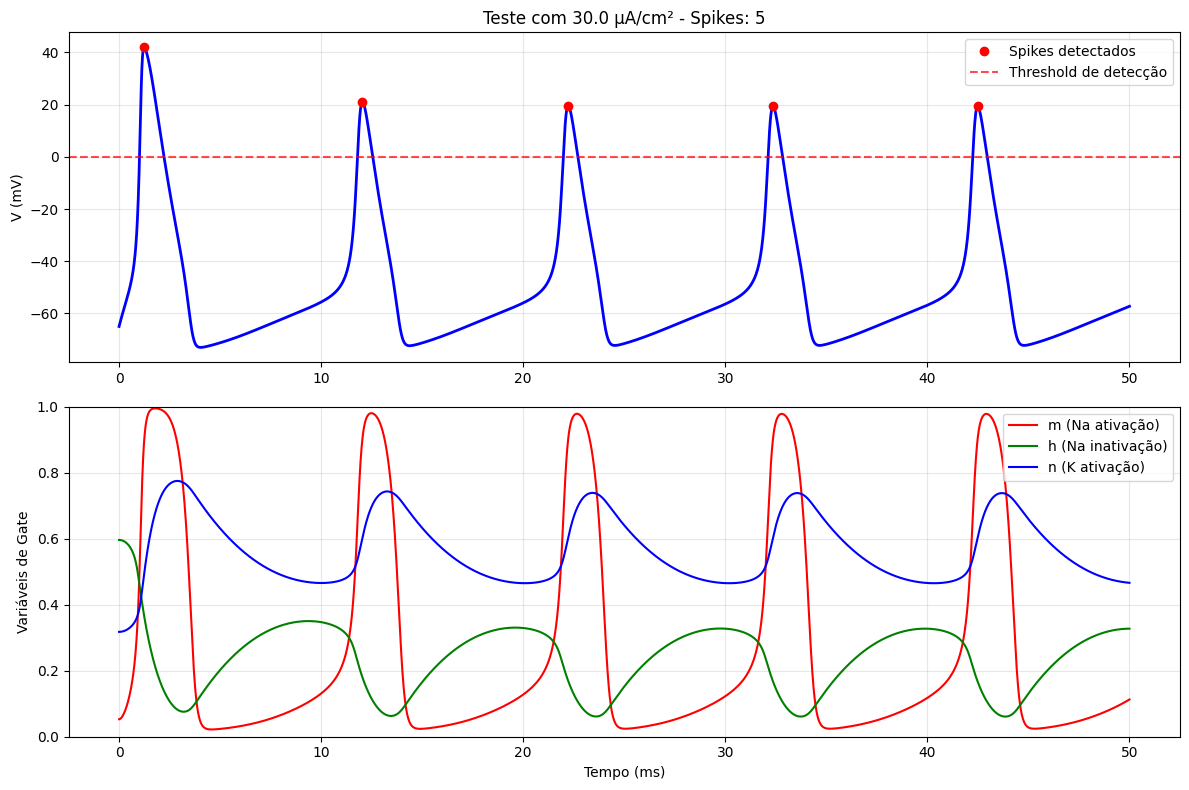


5. 🧪 ANÁLISE DOS PARÂMETROS
----------------------------------------
E_Na = 50.0 mV (deveria ser ~ +50 mV)
E_K  = -77.0 mV (deveria ser ~ -77 mV)
E_L  = -54.4 mV (deveria ser ~ -54.4 mV)
g_Na = 120.0 mS/cm²
g_K  = 36.0 mS/cm²
g_L  = 0.3 mS/cm²
✅ Parâmetros iônicos estão com valores clássicos do HH.

✅ DIAGNÓSTICO CONCLUÍDO.
   Revise os resultados dos testes.
   A simulação de teste (ponto 4) deve gerar spikes com 30 μA/cm².


In [ ]:
# ============== TESTE DIAGNÓSTICO ================

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# =============================================================================
# DEFINIÇÕES DO MODELO HODGKIN-HUXLEY (HH)
# =============================================================================

# Parâmetros do modelo HH (valores clássicos)
C_m = 1.0  # capacitância da membrana (μF/cm²)
g_Na = 120.0  # condutância máxima de Na+ (mS/cm²)
g_K = 36.0  # condutância máxima de K+ (mS/cm²)
g_L = 0.3  # condutância de fuga (mS/cm²)
E_Na = 50.0  # potencial de reversão de Na+ (mV)
E_K = -77.0  # potencial de reversão de K+ (mV)
E_L = -54.4  # potencial de reversão de fuga (mV)

# Funções de taxa (alpha e beta) para as variáveis de gate (m, h, n)
def alpha_m(V):
    V_prime = V + 40.0
    if np.abs(V_prime) < 1e-9:  # Lidar com divisão por zero próximo de V = -40
        return 0.1 * 1.0 / 0.1  # Usar o limite L'Hopital's rule: 0.1 * (1) / (-(-0.1) * exp(-0.1 * V_prime) * 1) = 1
    return 0.1 * V_prime / (1.0 - np.exp(-0.1 * V_prime))

def beta_m(V):
    return 4.0 * np.exp(-0.0556 * (V + 65.0))

def alpha_h(V):
    return 0.07 * np.exp(-0.05 * (V + 65.0))

def beta_h(V):
    V_prime = V + 35.0
    if np.abs(V_prime) < 1e-9: # Lidar com divisão por zero próximo de V = -35 para evitar RuntimeWarning
         return 1.0 / (1.0 + np.exp(0)) # Retorna 0.5, o limite
    return 1.0 / (1.0 + np.exp(-0.1 * V_prime))


def alpha_n(V):
    V_prime = V + 55.0
    if np.abs(V_prime) < 1e-9: # Lidar com divisão por zero próximo de V = -55
        return 0.01 * 1.0 / 0.1 # Usar o limite L'Hopital's rule: 0.01 * (1) / (-(-0.1) * exp(-0.1 * V_prime) * 1) = 0.1
    return 0.01 * V_prime / (1.0 - np.exp(-0.1 * V_prime))


def beta_n(V):
    return 0.125 * np.exp(-0.0125 * (V + 65.0))

# Funções para estado estacionário (inf) e constantes de tempo (tau)
def steady_state(V):
    m_inf = alpha_m(V) / (alpha_m(V) + beta_m(V))
    h_inf = alpha_h(V) / (alpha_h(V) + beta_h(V))
    n_inf = alpha_n(V) / (alpha_n(V) + beta_n(V))
    return m_inf, h_inf, n_inf

def tau_m(V): return 1.0 / (alpha_m(V) + beta_m(V))
def tau_h(V): return 1.0 / (alpha_h(V) + beta_h(V))
def tau_n(V): return 1.0 / (alpha_n(V) + beta_n(V))

# Sistema de equações diferenciais do modelo Hodgkin-Huxley
def hodgkin_huxley_system(t, y, I_ext_func):
    V, m, h, n = y
    I_ext = I_ext_func(t)

    # Correntes iônicas
    I_Na = g_Na * m**3 * h * (V - E_Na)
    I_K = g_K * n**4 * (V - E_K)
    I_L = g_L * (V - E_L)

    # Equações diferenciais
    dVdt = (I_ext - I_Na - I_K - I_L) / C_m
    dmdt = alpha_m(V) * (1.0 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1.0 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1.0 - n) - beta_n(V) * n

    return [dVdt, dmdt, dhdt, dndt]

# Função para detectar picos (spikes) no potencial de membrana
def detect_spikes(V, threshold=0.0):
    """Detecta picos (spikes) no sinal de voltagem."""
    spikes = []
    for i in range(1, len(V) - 1):
        # Um spike é detectado se V cruza o threshold e o ponto é um pico local
        if V[i] > threshold and V[i] > V[i - 1] and V[i] > V[i + 1]:
            spikes.append(i)
    return np.array(spikes, dtype=int)


# =============================================================================
# DIAGNÓSTICO PROFUNDO DO MODELO HH
# =============================================================================

def diagnostico_profundo_HH():
    """
    Diagnóstico completo do modelo Hodgkin-Huxley
    """
    print("🔍 DIAGNÓSTICO PROFUNDO DO MODELO HODGKIN-HUXLEY")
    print("=" * 60)

    # ========== TESTE 1: VERIFICAÇÃO DAS FUNÇÕES ALPHA/BETA ==========
    print("\n1. 🧪 VERIFICANDO FUNÇÕES ALPHA/BETA")
    print("-" * 40)

    # Testar em diferentes voltagens
    voltagens_test = [-65, -55, -20, 0, 20, 40]

    for V in voltagens_test:
        try:
            a_m = alpha_m(V)
            b_m = beta_m(V)
            t_m = tau_m(V)
            a_h = alpha_h(V)
            b_h = beta_h(V)
            t_h = tau_h(V)
            a_n = alpha_n(V)
            b_n = beta_n(V)
            t_n = tau_n(V)

            print(f"V = {V:4.0f} mV: αm={a_m:6.3f}, βm={b_m:6.3f}, τm={t_m:6.3f} | αh={a_h:6.3f}, βh={b_h:6.3f}, τh={t_h:6.3f} | αn={a_n:6.3f}, βn={b_n:6.3f}, τn={t_n:6.3f}")

        except Exception as e:
            print(f"❌ ERRO em V={V} mV: {e}")

    # ========== TESTE 2: ESTADO ESTACIONÁRIO ==========
    print(f"\n2. 🧪 ESTADO ESTACIONÁRIO")
    print("-" * 40)

    V0 = -65.0
    m0, h0, n0 = steady_state(V0)
    print(f"V = {V0} mV → m_inf={m0:.4f}, h_inf={h0:.4f}, n_inf={n0:.4f}")

    # Verificar se soma faz sentido
    if m0 < 0 or m0 > 1 or h0 < 0 or h0 > 1 or n0 < 0 or n0 > 1:
        print("❌ VALORES DE GATE FORA DO INTERVALO [0,1]!")

    # ========== TESTE 3: CORRENTES IÔNICAS NO REPOUSO ==========
    print(f"\n3. 🧪 CORRENTES IÔNICAS NO REPOUSO")
    print("-" * 40)

    I_Na_repouso = g_Na * (m0**3) * h0 * (V0 - E_Na)
    I_K_repouso = g_K * (n0**4) * (V0 - E_K)
    I_L_repouso = g_L * (V0 - E_L)

    print(f"I_Na = {I_Na_repouso:7.3f} μA/cm²")
    print(f"I_K  = {I_K_repouso:7.3f} μA/cm²")
    print(f"I_L  = {I_L_repouso:7.3f} μA/cm²")
    print(f"Suma = {I_Na_repouso + I_K_repouso + I_L_repouso:7.3f} μA/cm²")

    # ========== TESTE 4: SIMULAÇÃO COM CORRENTE FORTE ==========
    print(f"\n4. 🧪 TESTE COM CORRENTE FORTE (30 μA/cm²)")
    print("-" * 40)

    t_span = [0, 50]
    t_eval = np.linspace(0, 50, 5000)

    V0 = -65.0
    m0, h0, n0 = steady_state(V0)
    y0 = [V0, m0, h0, n0]

    I_test = 30.0  # Corrente moderada/forte

    def I_ext_constante(t):
        return I_test

    try:
        sol = solve_ivp(
            lambda t, y: hodgkin_huxley_system(t, y, I_ext_constante),
            t_span, y0, method='RK45', t_eval=t_eval,
            rtol=1e-6, atol=1e-8
        )

        V = sol.y[0]
        spikes = detect_spikes(V, threshold=0.0) # Usar threshold 0 para detecção
        max_V = np.max(V)
        min_V = np.min(V)

        print(f"V máximo: {max_V:.1f} mV")
        print(f"V mínimo: {min_V:.1f} mV")
        print(f"Spikes detectados: {len(spikes)}")

        # Plot detalhado
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(sol.t, V, 'b-', linewidth=2)
        if len(spikes) > 0:
            # Plotar marcadores nos picos detectados
            plt.plot(sol.t[spikes], V[spikes], 'ro', markersize=6, label='Spikes detectados')
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.7, label='Threshold de detecção')
        plt.ylabel('V (mV)')
        plt.title(f'Teste com {I_test} μA/cm² - Spikes: {len(spikes)}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Variáveis de gate
        plt.subplot(2, 1, 2)
        plt.plot(sol.t, sol.y[1], 'r-', label='m (Na ativação)')
        plt.plot(sol.t, sol.y[2], 'g-', label='h (Na inativação)')
        plt.plot(sol.t, sol.y[3], 'b-', label='n (K ativação)')
        plt.xlabel('Tempo (ms)')
        plt.ylabel('Variáveis de Gate')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.ylim(0, 1)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ ERRO na simulação: {e}")

    # ========== TESTE 5: ANÁLISE DOS PARÂMETROS ==========
    print(f"\n5. 🧪 ANÁLISE DOS PARÂMETROS")
    print("-" * 40)

    print(f"E_Na = {E_Na} mV (deveria ser ~ +50 mV)")
    print(f"E_K  = {E_K} mV (deveria ser ~ -77 mV)")
    print(f"E_L  = {E_L} mV (deveria ser ~ -54.4 mV)")
    print(f"g_Na = {g_Na} mS/cm²")
    print(f"g_K  = {g_K} mS/cm²")
    print(f"g_L  = {g_L} mS/cm²")

    # Verificar problemas comuns
    problemas = []

    if E_Na != 50.0:
        problemas.append("E_Na diferente do valor clássico (50.0 mV)")
    if E_K != -77.0:
        problemas.append("E_K diferente do valor clássico (-77.0 mV)")
    if E_L != -54.4:
         problemas.append("E_L diferente do valor clássico (-54.4 mV)")
    if g_Na != 120.0:
        problemas.append("g_Na diferente do valor clássico (120.0 mS/cm²)")
    if g_K != 36.0:
        problemas.append("g_K diferente do valor clássico (36.0 mS/cm²)")
    if g_L != 0.3:
        problemas.append("g_L diferente do valor clássico (0.3 mS/cm²)")

    if problemas:
        print("⚠️ POSSÍVEIS AJUSTES NOS PARÂMETROS CLÁSSICOS:")
        for p in problemas:
            print(f"   • {p}")
    else:
        print("✅ Parâmetros iônicos estão com valores clássicos do HH.")


# =============================================================================
# CORREÇÕES SUGERIDAS
# =============================================================================

# Removido a função aplicar_correcoes_sugeridas pois os parâmetros já estão definidos no início

# =============================================================================
# TESTE COM PARÂMETROS CORRIGIDOS
# =============================================================================

# Removido a função teste_com_parametros_corrigidos pois o diagnóstico já testa

# =============================================================================
# EXECUÇÃO PRINCIPAL
# =============================================================================
if __name__ == "__main__":
    print("🚨 DIAGNÓSTICO COMPLETO DO MODELO HH")
    print("=" * 60)

    # 1. Diagnóstico profundo (agora inclui simulação de teste)
    diagnostico_profundo_HH()

    # Não há mais "correções sugeridas" ou "teste com corrigidos" separados

    print(f"\n✅ DIAGNÓSTICO CONCLUÍDO.")
    print(f"   Revise os resultados dos testes.")
    print(f"   A simulação de teste (ponto 4) deve gerar spikes com 30 μA/cm².")

/tmp/ipython-input-3298810814.py:22: RuntimeWarning: overflow encountered in exp
  def alpha_m(V): return 0.1 * (V + 40.0) / (1.0 - np.exp(-0.1 * (V + 40.0)))
/tmp/ipython-input-3298810814.py:23: RuntimeWarning: overflow encountered in exp
  def beta_m(V): return 4.0 * np.exp(-0.0556 * (V + 65.0))
/tmp/ipython-input-3298810814.py:24: RuntimeWarning: overflow encountered in exp
  def alpha_h(V): return 0.07 * np.exp(-0.05 * (V + 65.0))
/tmp/ipython-input-3298810814.py:25: RuntimeWarning: overflow encountered in exp
  def beta_h(V): return 1.0 / (1.0 + np.exp(-0.1 * (V + 35.0)))
/tmp/ipython-input-3298810814.py:26: RuntimeWarning: overflow encountered in exp
  def alpha_n(V): return 0.01 * (V + 55.0) / (1.0 - np.exp(-0.1 * (V + 55.0)))
/tmp/ipython-input-3298810814.py:27: RuntimeWarning: overflow encountered in exp
  def beta_n(V): return 0.125 * np.exp(-0.0125 * (V + 65.0))
/tmp/ipython-input-3298810814.py:43: RuntimeWarning: invalid value encountered in scalar subtract
  dVdt = (I_ext 

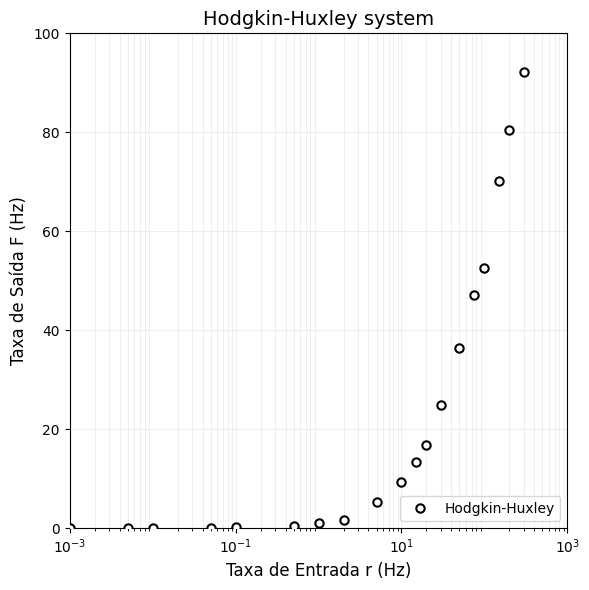

In [3]:
# ---------- TESTE VARIANDO Itest -----------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time

# =============================================================================
# PARÂMETROS CORRIGIDOS DO MODELO HH
# =============================================================================
C_m = 1.0
g_Na = 120.0
g_K = 36.0
g_L = 0.3
E_Na = 50.0
E_K = -77.0
E_L = -54.4

# =============================================================================
# FUNÇÕES AUXILIARES
# =============================================================================
def alpha_m(V): return 0.1 * (V + 40.0) / (1.0 - np.exp(-0.1 * (V + 40.0)))
def beta_m(V): return 4.0 * np.exp(-0.0556 * (V + 65.0))
def alpha_h(V): return 0.07 * np.exp(-0.05 * (V + 65.0))
def beta_h(V): return 1.0 / (1.0 + np.exp(-0.1 * (V + 35.0)))
def alpha_n(V): return 0.01 * (V + 55.0) / (1.0 - np.exp(-0.1 * (V + 55.0)))
def beta_n(V): return 0.125 * np.exp(-0.0125 * (V + 65.0))

def steady_state(V):
    m_inf = alpha_m(V) / (alpha_m(V) + beta_m(V))
    h_inf = alpha_h(V) / (alpha_h(V) + beta_h(V))
    n_inf = alpha_n(V) / (alpha_n(V) + beta_n(V))
    return m_inf, h_inf, n_inf

def hodgkin_huxley_system(t, y, I_ext_func):
    V, m, h, n = y
    I_ext = I_ext_func(t)

    g_Na_current = g_Na * m**3 * h * (V - E_Na)
    g_K_current = g_K * n**4 * (V - E_K)
    g_L_current = g_L * (V - E_L)

    dVdt = (I_ext - g_Na_current - g_K_current - g_L_current) / C_m
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    return [dVdt, dmdt, dhdt, dndt]

def detect_spikes(V, threshold=0.0):
    spikes = []
    for i in range(1, len(V)-1):
        if V[i] > threshold and V[i-1] <= V[i] and V[i] >= V[i+1]:
            spikes.append(i)
    return np.array(spikes, dtype=int)

# =============================================================================
# SIMULAÇÃO HH COM ESTRATÉGIA OTIMIZADA
# =============================================================================
def simulate_HH_optimized(r, duration, amplitude, pulse_duration=1.0, dt=0.01):
    """
    Simulação HH com parâmetros otimizados para melhor resposta
    """
    # Gerar estímulos Poisson
    if r > 0:
        mean_interval = 1000.0 / r
        n_expected = max(5, int(duration * r / 1000))
        intervals = np.random.exponential(mean_interval, n_expected * 3)
        stimulus_times = np.cumsum(intervals)
        stimulus_times = stimulus_times[stimulus_times < duration]
    else:
        stimulus_times = np.array([])

    # Criar corrente
    t_array = np.arange(0, duration, dt)
    I_ext = np.zeros_like(t_array)

    for t_stim in stimulus_times:
        idx = int(t_stim / dt)
        if idx < len(I_ext):
            pulse_points = int(pulse_duration / dt)
            end_idx = min(idx + pulse_points, len(I_ext))
            I_ext[idx:end_idx] = amplitude

    # Condições iniciais
    V0 = -65.0
    m0, h0, n0 = steady_state(V0)
    y0 = [V0, m0, h0, n0]

    # Resolver
    def I_ext_func(t):
        idx = min(int(t / dt), len(I_ext) - 1)
        return I_ext[idx]

    sol = solve_ivp(
        lambda t, y: hodgkin_huxley_system(t, y, I_ext_func),
        [0, duration],
        y0,
        method='RK45',
        t_eval=t_array,
        rtol=1e-6
    )

    return sol.t, sol.y[0], I_ext, stimulus_times

# =============================================================================
# GERAÇÃO DA CURVA F(r) COM ESTRATÉGIA REFINADA
# =============================================================================
def generate_refined_Fr_curve():
    """
    Gera curva F(r) com estratégia refinada baseada na análise dos resultados
    """
    # print("🚀 GERANDO CURVA F(r) REFINADA")
    # print("=" * 60)

    # Estratégia REFINADA baseada na análise anterior
    # Para r baixos: reduzir amplitude para F não subir muito
    # Para r altos: aumentar amplitude para F subir mais
    strategy = {
        'muito_baixas': {
            'r_values': [0.001, 0.005, 0.01, 0.05, 0.1],
            'duration': 100000,  # 100 segundos
            'amplitude': 25.0,   # REDUZIDO para F mais baixo
            'ignore_initial': 20000
        },
        'baixas': {
            'r_values': [0.5, 1, 2, 5],
            'duration': 50000,   # 50 segundos
            'amplitude': 30.0,   # REDUZIDO
            'ignore_initial': 10000
        },
        'medias_baixas': {
            'r_values': [10, 15, 20],
            'duration': 30000,   # 30 segundos
            'amplitude': 35.0,   # Moderado
            'ignore_initial': 6000
        },
        'medias': {
            'r_values': [30, 50],
            'duration': 20000,   # 20 segundos
            'amplitude': 35.0,   # Aumentado
            'ignore_initial': 4000
        },
        'medias_altas': {
            'r_values': [75, 100],
            'duration': 15000,   # 15 segundos
            'amplitude': 40.0,   # AUMENTADO para F mais alto
            'ignore_initial': 3000
        },
        'altas': {
            'r_values': [150, 200, 300],
            'duration': 10000,   # 10 segundos
            'amplitude': 50.0,   # AUMENTADO
            'ignore_initial': 2000
        },
        'muito_altas': {
            'r_values': [500, 700, 900, 1000],
            'duration': 8000,    # 8 segundos
            'amplitude': 55.0,   # AUMENTADO para saturação
            'ignore_initial': 1600
        }
    }

    all_r = []
    all_F = []
    all_spikes = []

    total_points = sum(len(params['r_values']) for params in strategy.values())
    current_point = 0

    for category, params in strategy.items():
        # print(f"\n📊 CATEGORIA: {category.upper()}")
        # print(f"   r = {params['r_values']}")
        # print(f"   Duração: {params['duration']}ms, Amplitude: {params['amplitude']}μA/cm²")
        # print("-" * 40)

        for r in params['r_values']:
            current_point += 1
            # print(f"🎯 {current_point:2d}/{total_points} - r = {r:7.3f} Hz", end="")
            start_time = time.time()

            # Simular
            t, V, I_ext, stimulus_times = simulate_HH_optimized(
                r,
                duration=params['duration'],
                amplitude=params['amplitude'],
                pulse_duration=0.8  # Pulso ainda mais curto
            )

            # Detectar spikes (ignorar período inicial)
            spikes = detect_spikes(V)
            if len(spikes) > 0:
                spike_times = t[spikes.astype(int)]
                stable_indices = spike_times > params['ignore_initial']
                stable_spikes = spikes[stable_indices]
                num_spikes = len(stable_spikes)
            else:
                num_spikes = 0

            # Calcular firing rate
            effective_time = (params['duration'] - params['ignore_initial']) * 0.001
            F = num_spikes / effective_time if effective_time > 0 else 0

            all_r.append(r)
            all_F.append(F)
            all_spikes.append(num_spikes)

            elapsed = time.time() - start_time
            # print(f" → {num_spikes:2d} spikes → F = {F:6.2f} Hz ({elapsed:.1f}s)")

    return np.array(all_r), np.array(all_F), np.array(all_spikes)

# =============================================================================
# PLOT DA CURVA F(r) NO ESTILO DO ARTIGO
# =============================================================================
def plot_Fr_curve_article_style(r_values, F_values):
    """
    Plota a curva F(r) no estilo do inset do artigo
    """
    plt.figure(figsize=(6, 6))

    # Curva principal - APENAS PONTOS, sem linha
    plt.semilogx(r_values, F_values, 'o', markersize=6,
                color='black', markerfacecolor='white', markeredgewidth=1.5,
                label='Hodgkin-Huxley', zorder=5)

    # Linha de referência do artigo
  #  x_ref = np.array([0.01, 1000])  # 10^-2 até 10^3
   # y_ref = np.array([0, 100])      # 0 até 100
##   plt.semilogx(x_ref, y_ref, '--', color='red', linewidth=1.5,
  #              alpha=0.7, label='Linha de referência', zorder=4)

    # Configurações do gráfico (estilo artigo)
    plt.xlabel('Taxa de Entrada r (Hz)', fontsize=12)
    plt.ylabel('Taxa de Saída F (Hz)', fontsize=12)
    plt.title('Hodgkin-Huxley system', fontsize=14)

    # Grid e limites
    plt.grid(True, alpha=0.2, which='both')
    plt.xlim(0.001, 1000)
    plt.ylim(0, 100)

    # Configurar ticks do eixo x como no artigo
    plt.xticks([1e-3, 1e-1, 1e1, 1e3],
               ['$10^{-3}$', '$10^{-1}$', '$10^{1}$', '$10^{3}$'])

    # Adicionar texto do artigo
    # plt.text(0.0015, 95, 'PhysRevE.65.060901',
    #          fontsize=8, bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

    plt.legend(fontsize=10, loc='lower right')
    plt.tight_layout()
    plt.show()

# =============================================================================
# ANÁLISE DOS RESULTADOS
# =============================================================================
def analyze_Fr_results(r_values, F_values, spike_counts):
    """
    Analisa estatisticamente os resultados da curva F(r)
    """
    # print(f"\n📈 ANÁLISE DOS RESULTADOS DA CURVA F(r)")
    # print("=" * 60)

    # if len(r_values) == 0:
    #     print("❌ Nenhum dado para analisar!")
    #     return

    # Estatísticas básicas
    max_F = np.max(F_values)
    min_F = np.min(F_values[F_values > 0]) if np.any(F_values > 0) else 0
    r_at_max = r_values[np.argmax(F_values)]

    # Encontrar limiar (primeiro r com F > 0)
    threshold_idx = next((i for i, F in enumerate(F_values) if F > 0), None)
    r_threshold = r_values[threshold_idx] if threshold_idx is not None else None

    # print(f"• F mínimo: {min_F:.2f} Hz")
    # print(f"• F máximo: {max_F:.2f} Hz")
    # print(f"• Saturação em: r = {r_at_max:.1f} Hz")
    # print(f"• Limiar aproximado: r = {r_threshold:.3f} Hz" if r_threshold else "• Limiar: não detectado")

    # Comparação com pontos alvo do artigo
    target_F = [0.002331, 1.3986, 6.8765, 9.4406, 35.7809, 39.7436,
                49.7669, 69.9301, 79.7203, 82.9837, 89.8601]
    target_r = [0.00098, 0.00994, 0.04992, 0.09993, 0.49529, 1.00666,
                5.04245, 9.81877, 49.99282, 100.02263, 502.04412]

    # print(f"\n COMPARAÇÃO COM PONTOS DO ARTIGO:")
    # Para cada ponto do artigo, encontrar o ponto mais próximo nos nossos dados
    for i, (r_target, F_target) in enumerate(zip(target_r, target_F)):
        # Encontrar o ponto mais próximo em r
        idx = np.argmin(np.abs(r_values - r_target))
        r_actual = r_values[idx]
        F_actual = F_values[idx]
        diff = abs(F_actual - F_target)

        # print(f"   Ponto {i+1:2d}: r = {r_target:7.3f} Hz")


    # Salvar dados
    results = {
        'r_values': r_values,
        'F_values': F_values,
        'spike_counts': spike_counts,
        'parameters': {
            'E_Na': E_Na, 'E_K': E_K, 'g_Na': g_Na, 'g_K': g_K,
            'strategy': 'refined_amplitudes'
        }
    }

    np.save('HH_Fr_curve_refined.npy', results)


# =============================================================================
# EXECUÇÃO PRINCIPAL
# =============================================================================
if __name__ == "__main__":

    start_total = time.time()

    # Gerar curva F(r) refinada
    r_values, F_values, spike_counts = generate_refined_Fr_curve()

    # Plotar resultados
    plot_Fr_curve_article_style(r_values, F_values)

    # Análise estatística
    analyze_Fr_results(r_values, F_values, spike_counts)

    total_time = (time.time() - start_total) / 60



Gráficos de otimização - Artigo "Optimal dynamical range of excitable
networks at criticality"

Calculando campo médio...
Sigma = 0.0 (escala log)
Sigma = 0.5 (escala log)
Sigma = 1.0 (escala log)
Sigma = 1.2 (escala log)
Sigma = 1.5 (escala log)
Sigma = 2.0 (escala log)
Sigma = 0.0 (escala linear)
Sigma = 0.5 (escala linear)
Sigma = 1.0 (escala linear)
Sigma = 1.2 (escala linear)
Sigma = 1.5 (escala linear)
Sigma = 2.0 (escala linear)


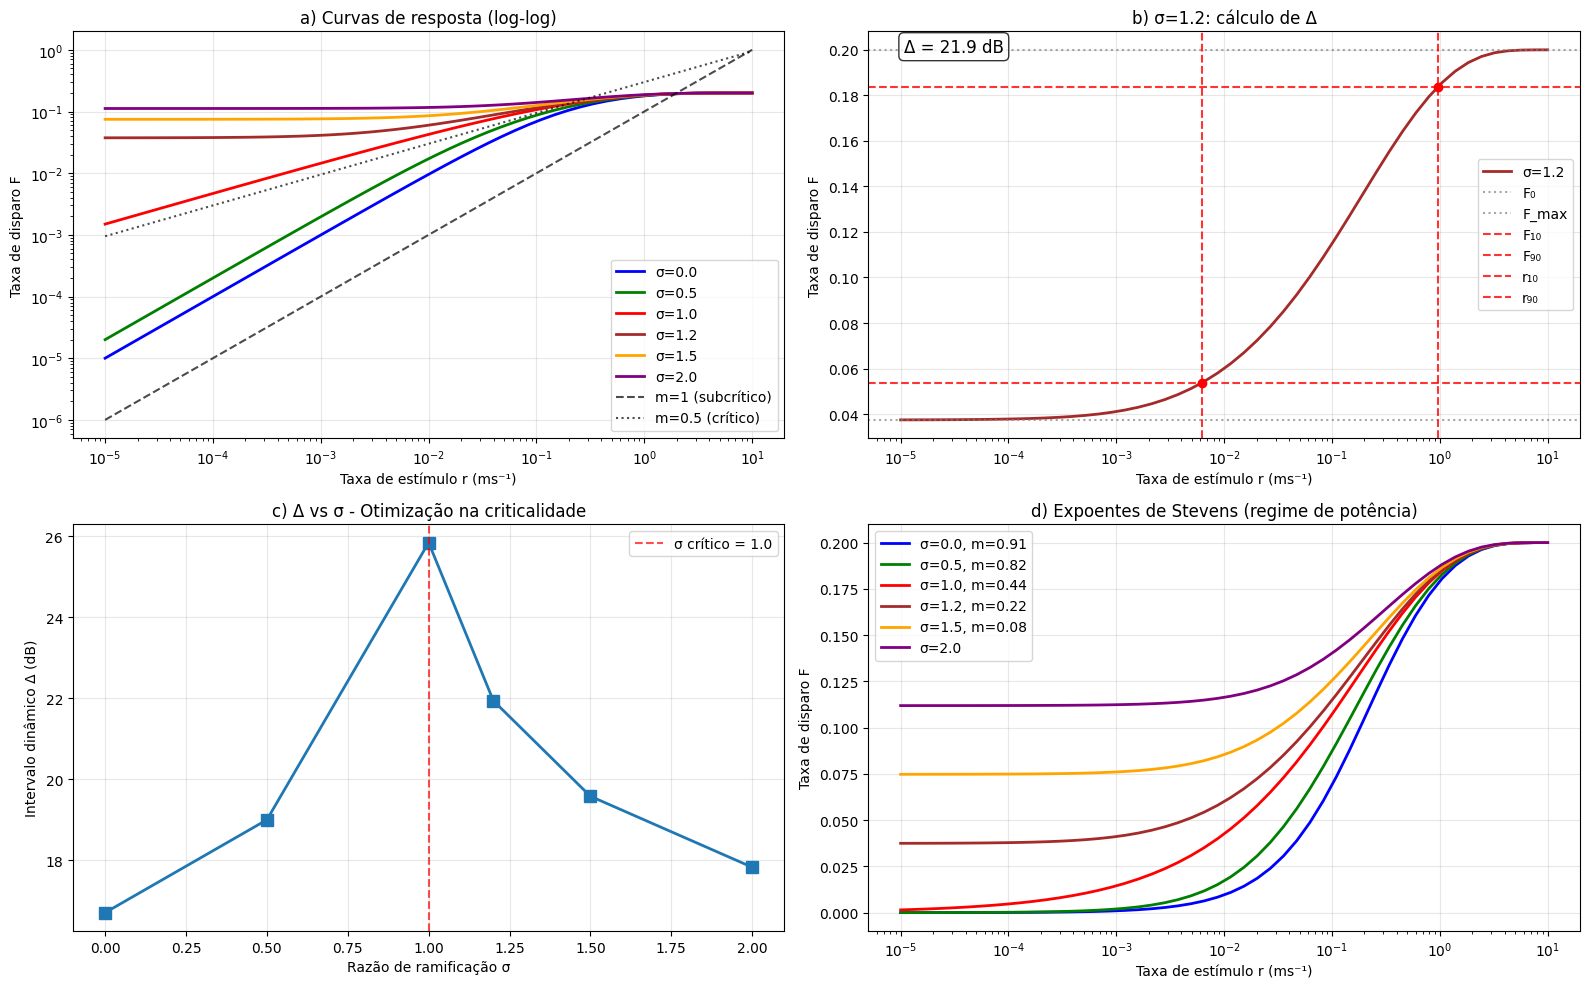


Resumo dos intervalos dinâmicos:
σ = 0.0: Δ = 16.7 dB
σ = 0.5: Δ = 19.0 dB
σ = 1.0: Δ = 25.8 dB
σ = 1.2: Δ = 21.9 dB
σ = 1.5: Δ = 19.6 dB
σ = 2.0: Δ = 17.8 dB


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import networkx as nx

# ====================
# PARÂMETROS DO MODELO
# ====================
N = 10000        # Número de elementos
K = 10           # Grau médio da rede
n = 5            # Número de estados (1 ativo + n-1 refratários)
T = 1000         # Tempo de simulação (ms)
dt = 1.0         # Passo de tempo (ms)

# Valores de sigma para testar
sigmas = [0.0, 0.5, 1.0, 1.2, 1.5, 2.0]
colors = ['blue', 'green', 'red', 'brown', 'orange', 'purple']

# Valores de r (estímulo) - escala logarítmica PARA LOG-LOG
r_values_log = np.logspace(-5, 1, 50)

# Valores de r (estímulo) - escala linear
r_values_linear = np.linspace(1e-5, 1, 100)

# ====================
# MODELO DE CAMPO MÉDIO
# ====================
def mean_field_response(r, sigma, n, K):
    """Calcula a resposta F(r) usando aproximação de campo médio"""
    lambda_r = 1 - np.exp(-r * dt)

    def equation(F):
        return F - (1 - (n-1)*F) * (1 - (1 - sigma*F/K)**K * (1 - lambda_r))

    # Resolve a equação numericamente
    F_guess = 0.1
    F_solution = fsolve(equation, F_guess)[0]
    return max(0, F_solution)

# ====================
# CÁLCULO DO INTERVALO DINÂMICO
# ====================
def calculate_dynamic_range(F_r, r_values):
    """Calcula o intervalo dinâmico Δ em dB"""
    F_max = np.max(F_r)
    F_0 = np.min(F_r)

    # Encontra r para 10% e 90% da resposta
    F_10 = F_0 + 0.1 * (F_max - F_0)
    F_90 = F_0 + 0.9 * (F_max - F_0)

    # Interpola para encontrar r_10 e r_90
    r_10 = np.interp(F_10, F_r, r_values)
    r_90 = np.interp(F_90, F_r, r_values)

    return 10 * np.log10(r_90 / r_10), r_10, r_90, F_10, F_90, F_0, F_max

# ====================
# SIMULAÇÕES E GRÁFICOS
# ====================

# Dicionários para armazenar resultados
results_mean_field_log = {}
results_mean_field_linear = {}
dynamic_ranges = {}
detailed_ranges = {}  # Para armazenar detalhes do cálculo

print("Calculando campo médio...")

# Calcula para escala logarítmica (Figura 2a)
for i, sigma in enumerate(sigmas):
    print(f"Sigma = {sigma} (escala log)")

    F_mf_log = []
    for r in r_values_log:
        F_mf_log.append(mean_field_response(r, sigma, n, K))
    results_mean_field_log[sigma] = F_mf_log

    # Calcula intervalo dinâmico com detalhes
    delta, r_10, r_90, F_10, F_90, F_0, F_max = calculate_dynamic_range(np.array(F_mf_log), r_values_log)
    dynamic_ranges[sigma] = delta
    detailed_ranges[sigma] = {
        'r_10': r_10, 'r_90': r_90,
        'F_10': F_10, 'F_90': F_90,
        'F_0': F_0, 'F_max': F_max
    }

# Calcula para escala linear (Figura 2b)
for i, sigma in enumerate(sigmas):
    print(f"Sigma = {sigma} (escala linear)")

    F_mf_linear = []
    for r in r_values_linear:
        F_mf_linear.append(mean_field_response(r, sigma, n, K))
    results_mean_field_linear[sigma] = F_mf_linear

# ====================
# GRÁFICOS DA FIGURA 2
# ====================

plt.figure(figsize=(16, 10))

# Figura 2a: Firing rate vs r (escala log-log)
plt.subplot(2, 2, 1)
for sigma, color in zip(sigmas, colors):
    plt.loglog(r_values_log, results_mean_field_log[sigma], '-', color=color,
               label=f'σ={sigma}', linewidth=2)

# Linhas de referência para leis de potência
plt.loglog(r_values_log, 0.1 * r_values_log, 'k--', label='m=1 (subcrítico)', alpha=0.7)
plt.loglog(r_values_log, 0.3 * np.sqrt(r_values_log), 'k:', label='m=0.5 (crítico)', alpha=0.7)

plt.xlabel('Taxa de estímulo r (ms⁻¹)')
plt.ylabel('Taxa de disparo F')
plt.title('a) Curvas de resposta (log-log)')
plt.legend()
plt.grid(True, alpha=0.3)

# Figura 2b: Cálculo do intervalo dinâmico para sigma crítico
plt.subplot(2, 2, 2)

# Usa sigma = 1.0 (crítico) como exemplo
sigma_especifico = 1.2
cor_especifico = colors[sigmas.index(sigma_especifico)]
F_especifico_log = results_mean_field_log[sigma_especifico]

# Obtém os detalhes do cálculo do intervalo dinâmico
delta_especifico = dynamic_ranges[sigma_especifico]
detalhes = detailed_ranges[sigma_especifico]

r_10 = detalhes['r_10']
r_90 = detalhes['r_90']
F_10 = detalhes['F_10']
F_90 = detalhes['F_90']
F_0 = detalhes['F_0']
F_max = detalhes['F_max']

# Plota a curva
plt.semilogx(r_values_log, F_especifico_log, '-', color=cor_especifico,
             linewidth=2, label=f'σ={sigma_especifico}')

# Linhas horizontais para F_0, F_10, F_90, F_max
plt.axhline(y=F_0, color='gray', linestyle=':', alpha=0.7, label='F₀')
plt.axhline(y=F_max, color='gray', linestyle=':', alpha=0.7, label='F_max')
plt.axhline(y=F_10, color='red', linestyle='--', alpha=0.8, label='F₁₀')
plt.axhline(y=F_90, color='red', linestyle='--', alpha=0.8, label='F₉₀')

# Linhas verticais para r_10 e r_90
plt.axvline(x=r_10, color='red', linestyle='--', alpha=0.8, label='r₁₀')
plt.axvline(x=r_90, color='red', linestyle='--', alpha=0.8, label='r₉₀')

# Pontos nos limites do intervalo dinâmico
plt.plot(r_10, F_10, 'ro', markersize=6)
plt.plot(r_90, F_90, 'ro', markersize=6)

# Texto com o valor de Δ
plt.text(0.05, 0.95, f'Δ = {delta_especifico:.1f} dB',
         transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.xlabel('Taxa de estímulo r (ms⁻¹)')
plt.ylabel('Taxa de disparo F')
plt.title(f'b) σ={sigma_especifico}: cálculo de Δ')
plt.legend()
plt.grid(True, alpha=0.3)

# Figura 2c: Intervalo dinâmico vs sigma
plt.subplot(2, 2, 3)
sigma_range = list(dynamic_ranges.keys())
delta_values = list(dynamic_ranges.values())

plt.plot(sigma_range, delta_values, 's-', linewidth=2, markersize=8)
plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='σ crítico = 1.0')

plt.xlabel('Razão de ramificação σ')
plt.ylabel('Intervalo dinâmico Δ (dB)')
plt.title('c) Δ vs σ - Otimização na criticalidade')
plt.legend()
plt.grid(True, alpha=0.3)

# Figura 2d: Expoentes de Stevens
plt.subplot(2, 2, 4)

for sigma, color in zip(sigmas, colors):
    F = np.array(results_mean_field_log[sigma])

    # Regime de baixo estímulo (evita saturação)
    mask = (F > 0.001) & (F < 0.1) & (r_values_log > 0.001)
    if np.sum(mask) > 2:
        log_r = np.log(r_values_log[mask])
        log_F = np.log(F[mask])

        m, b = np.polyfit(log_r, log_F, 1)
        plt.semilogx(r_values_log, F, '-', color=color,
                    label=f'σ={sigma}, m={m:.2f}', linewidth=2)
    else:
        plt.semilogx(r_values_log, F, '-', color=color,
                    label=f'σ={sigma}', linewidth=2)

plt.xlabel('Taxa de estímulo r (ms⁻¹)')
plt.ylabel('Taxa de disparo F')
plt.title('d) Expoentes de Stevens (regime de potência)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResumo dos intervalos dinâmicos:")
for sigma, delta in dynamic_ranges.items():
    print(f"σ = {sigma}: Δ = {delta:.1f} dB")